In [3]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
!pip install matplotlib 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
All required packages have been successfully installed!


In [2]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

## 获取CIFAR-10 dataset

CIFAR-10 是一个用于对象识别的经典数据集，由 Alex Krizhevsky、Vinod Nair 和 Geoffrey Hinton 收集。

它的特点可以概括为 "10-60000-32"：

10 类物体：包含飞机、汽车、鸟、猫、鹿、狗、青蛙、马、船、卡车。

60,000 张图片：其中 50,000 张用于训练，10,000 张用于测试。

32×32 分辨率：图片非常小（彩色 RGB），这使得它对电脑配置要求不高，非常适合初学者练手。

In [4]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),    # 先在图片周围填充4个像素，再随机裁剪回 $32 \times 32$。这像是在教模型：“即使物体位置稍微偏了一点，你也要认得它。”
        RandomHorizontalFlip(),   # 随机水平翻转图片。告诉模型：“左边的猫和右边的猫都是猫。”
        ToTensor(),   # 它把图片的像素值（0-255）缩放到 $0.0$ 到 $1.0$ 之间，并将图片格式从 HWC（高、宽、通道）转换为 PyTorch 喜欢的 CHW（通道、高、宽）张量格式。
    ]),
    "test": ToTensor(),
}
# 数据集
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],    # transform参数是对图片进行的预处理
  )
# 数据加载器
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,   # 每次给模型“喂” 512 张图片。
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

100%|██████████| 170M/170M [00:07<00:00, 22.6MB/s] 


## 定义模型

定义模型框架

In [ ]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))    # OrderedDict(layers) 的作用就是把这个列表转换成一个有序字典。PyTorch 的 nn.Sequential 如果接收到一个 OrderedDict，它就会使用字典里的 Key 作为这一层的名字，而不是用默认的数字编号。
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

In [ ]:
def download_url(url, model_dir='.', overwrite=False):
    '''将url中的内容下载到指定model_dir下, 命名为文件本身名称'''
    import os, sys, ssl
    from urllib.request import urlretrieve
    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

加载模型参数

In [ ]:
checkpoint_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(checkpoint['state_dict'])     # 一个匿名函数，recover_model()即可将模型参数恢复初始状态

Downloading: "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth" to ./vgg.cifar.pretrained.pth


=> loading checkpoint 'https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


## 评估初始化时模型的准确度和模型大小

评估函数

In [9]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

获取模型大小函数

In [ ]:
def get_model_macs(model, inputs) -> int:
    '''
    此函数调用pytorch中的profile_macs函数统计model在指定输入下的数学运算次数
    MACs 的全称是 Multiply-Accumulate Operations（乘加累积运算）。
    '''
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [12]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%
dense model has size=35.20 MiB


## 查看weight values的分布

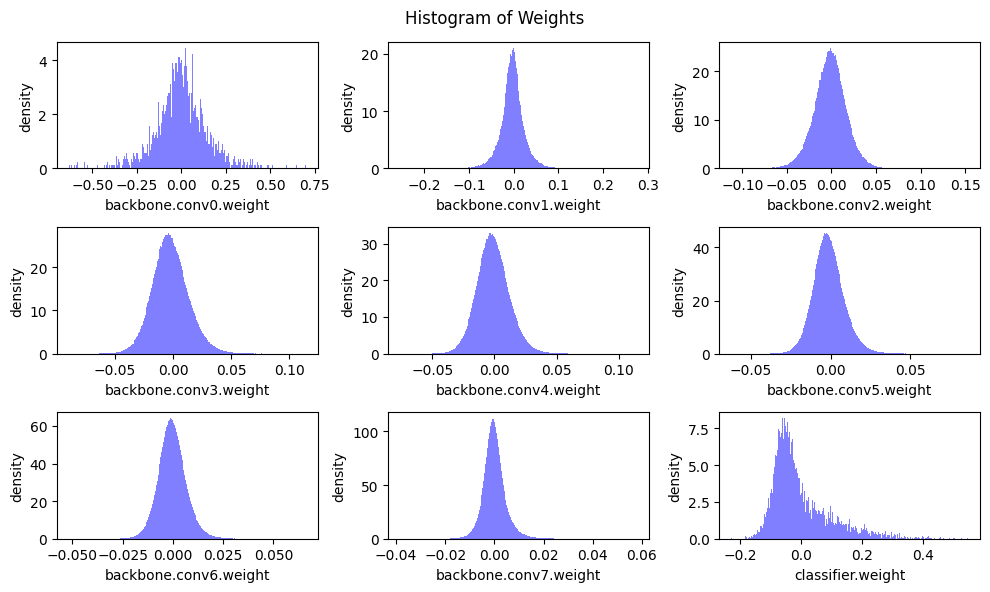

In [ ]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:     # 维度大于 1 的通常是卷积核权重或全连接层权重。维度等于 1 的通常是偏置（Bias）或 BatchNorm 的参数。我们显然只想看核心权重的分布。
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()       # 将参数拉伸为1维，并加载到cpu上
                param_cpu = param_cpu[param_cpu != 0].view(-1)  # 去除参数值为0的值
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,     # density=True 则直方图y轴为概率密度(图面积大小和为1)
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

观察到大量weight values为0, 可以对这些weight values为0的weight进行pruning

## Fine-grained Pruning 细粒度剪枝

**原理**

Fine-grained pruning removes the synapses with lowest importance. The weight tensor $W$ will become sparse after fine-grained pruning, which can be described with **sparsity**:

> $\mathrm{sparsity} := \#\mathrm{Zeros} / \#W = 1 - \#\mathrm{Nonzeros} / \#W$

where $\#W$ is the number of elements in $W$.

In practice, given the target sparsity $s$, the weight tensor $W$ is multiplied with a binary mask $M$ to disregard removed weight:

> $v_{\mathrm{thr}} = \texttt{kthvalue}(Importance, \#W \cdot s)$
>
> $M = Importance > v_{\mathrm{thr}}$
>
> $W = W \cdot M$

where $Importance$ is importance tensor with the same shape of $W$, $\texttt{kthvalue}(X, k)$ finds the $k$-th smallest value of tensor $X$, $v_{\mathrm{thr}}$ is the threshold value.
 **1** in the `mask` indicates the synapse will be kept, and **0** in the `mask` indicates the synapse will be removed. 

In [ ]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor: 将tensor的稀疏度变为指定的稀疏度, 并返回mask(Tensor类型, 为原Tensor中值变为0后的位置)
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round()) 我认为这里的意思其实让我们计算tensor进行剪枝后要变成0的元素个数
    num_zeros = round(sparsity * num_elements)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    # Step 3: calculate the pruning threshold
    # # torch.kthvalue(input, k, dim=None, keepdim=False, *, out=None)
    # Returns a namedtuple (values, indices) where values is the k th smallest element of 
    # each row of the input tensor in the given dimension dim. 
    # And indices is the index location of each element found.
    threshold = torch.kthvalue(importance.view(-1), num_zeros)[0]   # 注意其是在整个tensor中找到能够使得tensor有num_zeros个0值的阀值
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    # torch.gt(input, other, *, out=None) → Tensor
    mask = torch.gt(importance, threshold)
    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

测试`fine_grained_prune`函数正确性

In [24]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')

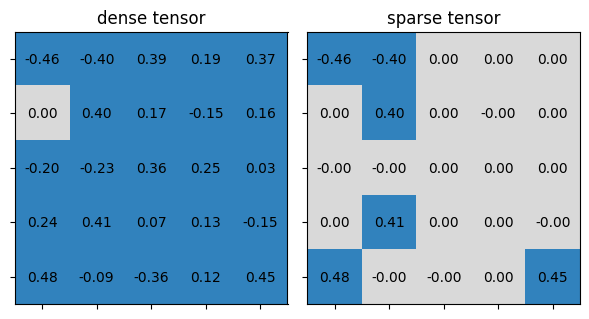

* Test fine_grained_prune()
    target sparsity: 0.75
        sparsity before pruning: 0.04
        sparsity after pruning: 0.76
        sparsity of pruning mask: 0.76
* Test passed.


In [25]:
test_fine_grained_prune()

The last cell plots the tensor before and after pruning. Nonzeros are rendered in blue while zeros are rendered in gray. Please modify the value of `target_sparsity` in the following code cell so that there are only 10 nonzeros in the sparse tensor after pruning.

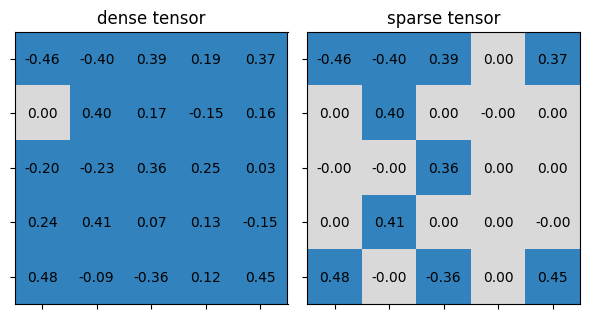

* Test fine_grained_prune()
    target sparsity: 0.60
        sparsity before pruning: 0.04
        sparsity after pruning: 0.60
        sparsity of pruning mask: 0.60
* Test passed.


In [27]:
##################### YOUR CODE STARTS HERE #####################
target_sparsity = (25 - 10) / 25 # please modify the value of target_sparsity
##################### YOUR CODE ENDS HERE #####################
test_fine_grained_prune(target_sparsity=target_sparsity, target_nonzeros=10)

### 将Fine-grained Pruning运用于整个模型

如上代码`fine_grained_prune`只是将指定tensor的稀疏度转变成指定稀疏度，我们要将此方法运用于整个model

其中方法也很简单，因为整个model的每一层就是由weight组成，weight就是tensor

同时我们希望记录稀疏之后各个weight稀疏的位置(即各个weight的mask)

In [ ]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        '''
        将模型各个weight"打上"mask, 即进行稀疏化
        '''
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

## 如何决定model各层weight的稀疏度 -- Sensitivity Scan

此方法简单来说就是对每一层weight尝试不同的稀疏度，运行模型测试accuracy, 记录accuracy vs. sparsity的sensitivity curve

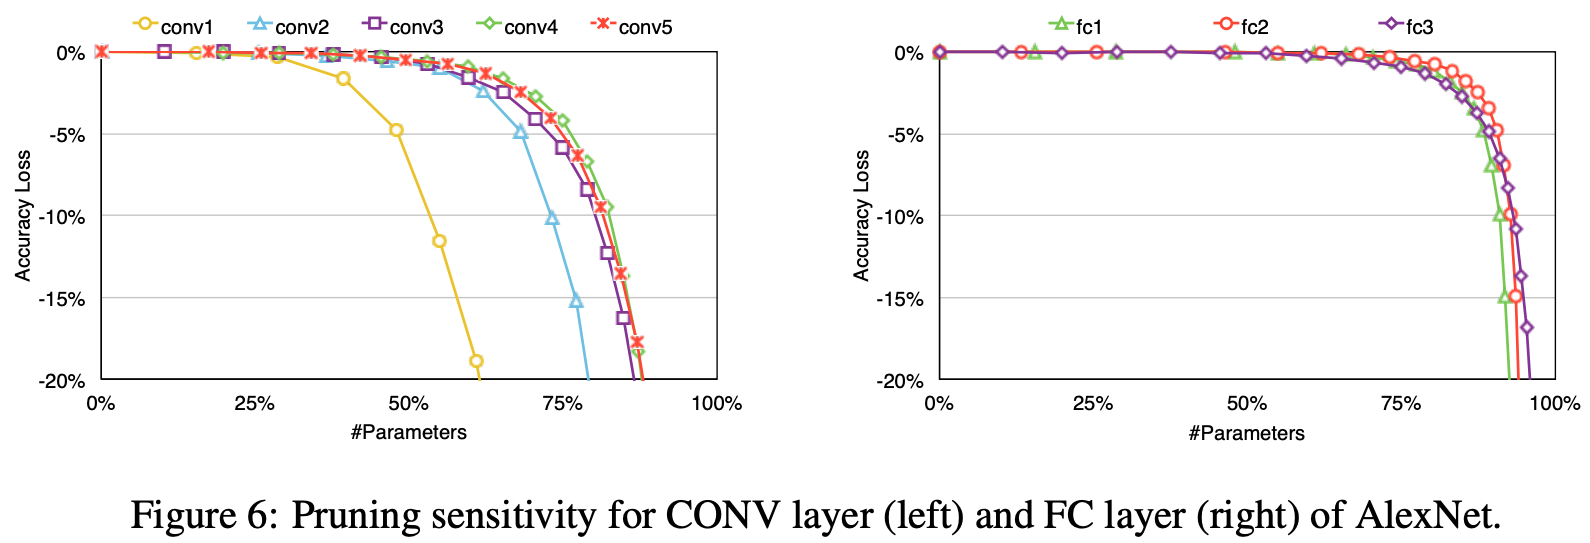

In [39]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.1, scan_end=1.0, verbose=True):
    ''' 
    依次遍历model所有weight层, 针对某一层weight进行稀疏化, 稀疏度从scan_start开始到scan_end进行测试, 每次稀疏度stride为scan_step
    并保存此层weight稀疏度改变时对模型精度的变化
    '''
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)   # param.detach() 产生的张量与原始 param 共享内存。你在 detach 后的张量上剪枝，原始模型的权重也会受到影响。
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies 

In [40]:
recover_model()
sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.1, scan_start=0.1, scan_end=1.0)

scanning 0/9 weight - backbone.conv0.weight:   0%|          | 0/9 [00:00<?, ?it/s]

    sparsity=[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.93%, 92.96%, 92.60%, 92.42%, 91.19%, 87.55%, 83.39%, 69.43%, 31.82%]

scanning 1/9 weight - backbone.conv1.weight:   0%|          | 0/9 [00:00<?, ?it/s]

    sparsity=[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.91%, 92.97%, 92.93%, 92.88%, 92.71%, 92.40%, 91.32%, 84.78%]

scanning 2/9 weight - backbone.conv2.weight:   0%|          | 0/9 [00:00<?, ?it/s]

    sparsity=[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.95%, 92.94%, 92.94%, 92.64%, 92.46%, 91.77%, 89.85%, 78.56%]

scanning 3/9 weight - backbone.conv3.weight:   0%|          | 0/9 [00:00<?, ?it/s]

    sparsity=[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.95%, 92.98%, 92.91%, 92.86%, 92.72%, 92.23%, 91.09%, 85.35%, 51.29%]

scanning 4/9 weight - backbone.conv4.weight:   0%|          | 0/9 [00:00<?, ?it/s]

    sparsity=[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.92%, 92.91%, 92.87%, 92.88%, 92.68%, 92.22%, 89.47%, 76.86%, 38.78%]

scanning 5/9 weight - backbone.conv5.weight:   0%|          | 0/9 [00:00<?, ?it/s]

    sparsity=[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.93%, 92.94%, 92.92%, 92.71%, 92.63%, 91.88%, 89.90%, 82.21%]

scanning 6/9 weight - backbone.conv6.weight:   0%|          | 0/9 [00:00<?, ?it/s]

    sparsity=[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.95%, 92.95%, 92.95%, 92.95%, 92.86%, 92.65%, 92.10%, 90.58%, 83.64%]

scanning 7/9 weight - backbone.conv7.weight:   0%|          | 0/9 [00:00<?, ?it/s]

    sparsity=[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.95%, 92.95%, 92.93%, 92.93%, 92.90%, 92.89%, 92.81%, 92.63%, 91.34%]

scanning 8/9 weight - classifier.weight:   0%|          | 0/9 [00:00<?, ?it/s]

    sparsity=[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.93%, 92.92%, 92.94%, 92.91%, 92.83%, 92.82%, 92.97%, 92.67%, 92.52%]

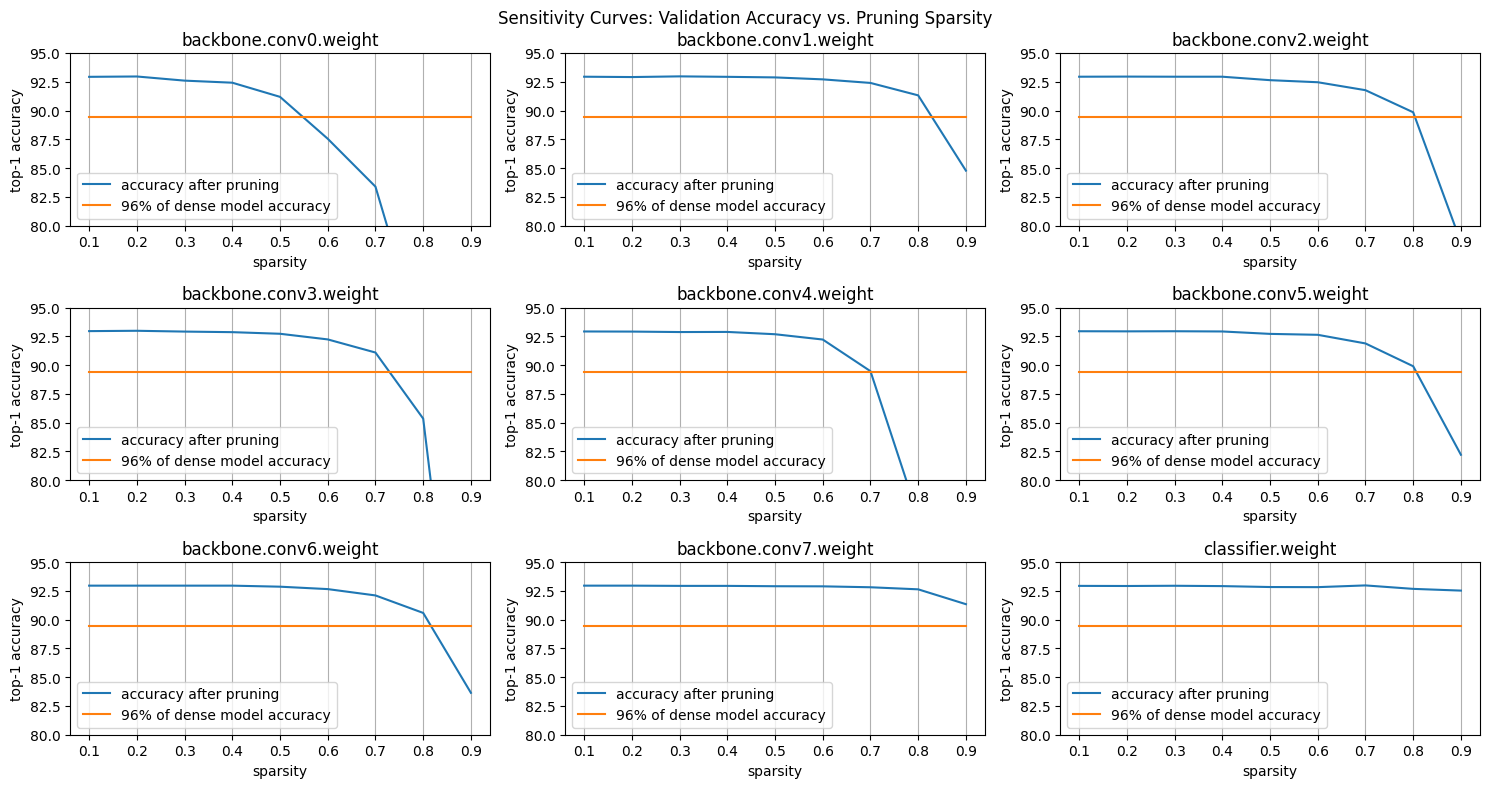

In [43]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy, scan_step=0.1, scan_start=0.1, scan_end=1.0):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(15,8))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(scan_start, scan_end, scan_step))
            ax.set_ylim(80, 95)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy, scan_step=0.1, scan_start=0.1, scan_end=1.0)

## 如何决定model各层weight的稀疏度 -- Parameters of each layer

Layers with more #parameters require larger sparsities. 因为剪枝模型的整体压缩率主要取决于参数数量较大的层

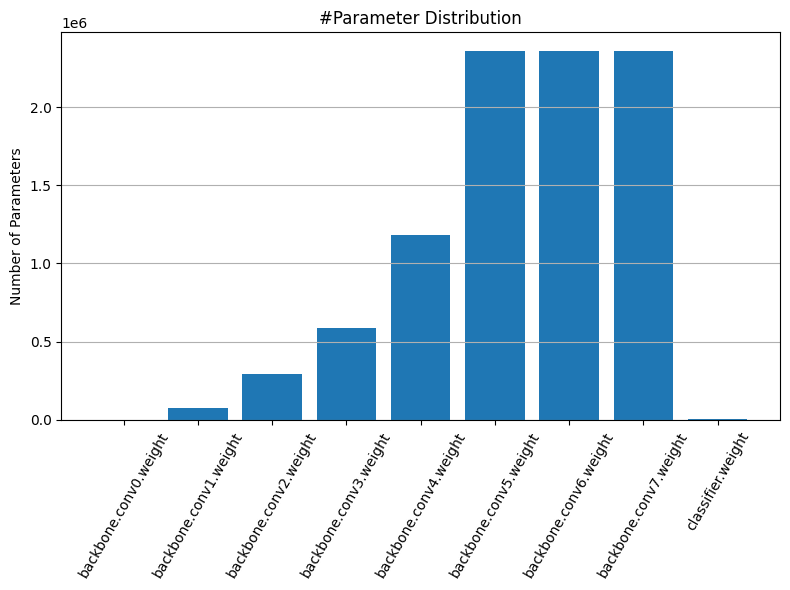

In [ ]:
def plot_num_parameters_distribution(model):
    '''
    画出模型各层weight参数量
    '''
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

## Select Sparsity Based on Sensitivity Curves and #Parameters Distribution

The layer with more #parameters should have larger sparsity. (see Figure #Parameter Distribution) \
The layer that is sensitive to the pruning sparsity (i.e., the accuracy will drop quickly as sparsity becomes higher) should have smaller sparsity. (see Figure Sensitivity Curves)

Please make sure that after pruning, the sparse model is 25% of the size of the dense model, and validation accuracy is higher than 92.5 after finetuning.

In [55]:
# 得到model各weight参数大小
all_num_parameters = 0
num_parameters = dict()
for name, param in model.named_parameters():
    if param.dim() > 1:
        num_parameters[name] = param.numel()
        all_num_parameters += num_parameters[name]

print(num_parameters)

# 先设置一个预定值, 求解出value为0的sparsity
sparsity_dict = {
    'backbone.conv0.weight': 0.4,
    'backbone.conv1.weight': 0.7,
    'backbone.conv2.weight': 0.6,
    'backbone.conv3.weight': 0.6,
    'backbone.conv4.weight': 0.6,
    'backbone.conv5.weight': 0,
    'backbone.conv6.weight': 0,
    'backbone.conv7.weight': 0.9,
    'classifier.weight': 0.9
}

all_num_parameters *= 0.75  # 因为稀疏之后的模型需要为原来模型大小的25%，所以这里稀疏量是占75%
denominator = 0
for name, num_parameter in num_parameters.items():
    if sparsity_dict[name] > 0:
        all_num_parameters -= sparsity_dict[name] * num_parameter
    else:
        denominator += num_parameter
value = all_num_parameters / denominator
print(value)

{'backbone.conv0.weight': 1728, 'backbone.conv1.weight': 73728, 'backbone.conv2.weight': 294912, 'backbone.conv3.weight': 589824, 'backbone.conv4.weight': 1179648, 'backbone.conv5.weight': 2359296, 'backbone.conv6.weight': 2359296, 'backbone.conv7.weight': 2359296, 'classifier.weight': 5120}
0.7413716634114583


After pruning with sparsity dictionary
  backbone.conv0.weight: 0.40
  backbone.conv1.weight: 0.70
  backbone.conv2.weight: 0.60
  backbone.conv3.weight: 0.60
  backbone.conv4.weight: 0.60
  backbone.conv5.weight: 0.74
  backbone.conv6.weight: 0.74
  backbone.conv7.weight: 0.90
  classifier.weight: 0.90
The sparsity of each layer becomes
  backbone.conv0.weight: 0.40
  backbone.conv1.weight: 0.70
  backbone.conv2.weight: 0.60
  backbone.conv3.weight: 0.60
  backbone.conv4.weight: 0.60
  backbone.conv5.weight: 0.74
  backbone.conv6.weight: 0.74
  backbone.conv7.weight: 0.90
  classifier.weight: 0.90
Sparse model has size=8.80 MiB = 24.99% of dense model size


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=86.30% before fintuning


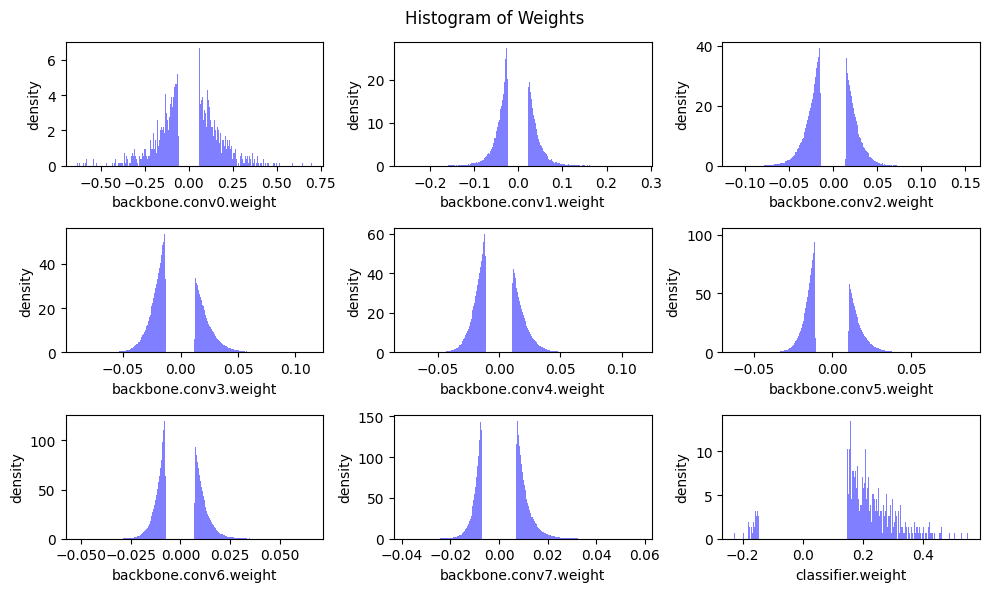

In [57]:
recover_model()     # 恢复模型参数

sparsity_dict = {
##################### YOUR CODE STARTS HERE #####################
    # please modify the sparsity value of each layer
    # please DO NOT modify the key of sparsity_dict
    'backbone.conv0.weight': 0.4,
    'backbone.conv1.weight': 0.7,
    'backbone.conv2.weight': 0.6,
    'backbone.conv3.weight': 0.6,
    'backbone.conv4.weight': 0.6,
    'backbone.conv5.weight': 0.743,
    'backbone.conv6.weight': 0.742,
    'backbone.conv7.weight': 0.9,
    'classifier.weight': 0.9
##################### YOUR CODE ENDS HERE #######################
}

pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)

## 对剪枝后的模型进行微调

In [58]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        # 这里一般传入callbacks=[lambda: pruner.apply(model)]
        # 目的是让model weight原本稀疏化后为0的位置上的数值依旧为0
        for callback in callbacks:
            callback()

In [59]:
num_finetune_epochs = 5     # 过5遍完整的数据 
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
# CosineAnnealingLR（余弦退火调度器）的作用是：让学习率按照余弦函数的曲线，随着训练轮数（Epoch）的增加而逐渐降低。作用为更新下一轮的学习率
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)  
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 1 Accuracy 92.55% / Best Accuracy: 92.55%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 2 Accuracy 92.74% / Best Accuracy: 92.74%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 3 Accuracy 92.74% / Best Accuracy: 92.74%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 4 Accuracy 92.83% / Best Accuracy: 92.83%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 5 Accuracy 92.77% / Best Accuracy: 92.83%


In [60]:
# load the best sparse model checkpoint to evaluate the final performance
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

Sparse model has size=8.80 MiB = 24.99% of dense model size


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=92.83% after fintuning


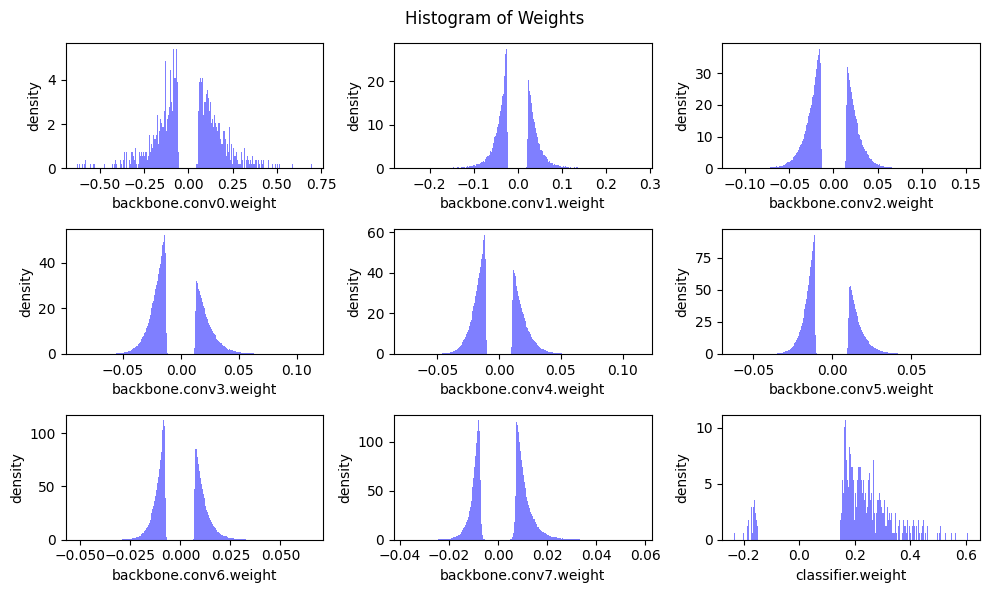

In [61]:
plot_weight_distribution(model, count_nonzero_only=True)

**总结**

Fine-graining Fruning 基本思想为将tensor中0~第k-th小的数值都认为是不重要的（k-th取决于你的稀疏度设置为多少），这些数值最后将会被设置为0

我们需要决定model 每层weight稀疏度应该设置为多少，判断方法为结合1. Sensitivity Scan 2. Parmeters size

weight对稀疏度越敏感(即稀疏度大，模型准确度下降得越快)，我们就要将其稀疏度设置地更小一点
weight的Parameter size越大，我们可以将其稀疏度设置地大点，这样其能够贡献更多的模型压缩率

我们需要权衡 稀疏度/模型准确度 之间的关系， 上述我们用到的方法还只是人为设置，非常麻烦

## Channel pruning

感觉主要是一种针对有卷积层的pruning操作

**原理**

Unlike fine-grained pruning, we can remove the weights entirely from the tensor in channel pruning. That is to say, the number of output channels is reduced:

#out_channelsnew=#out_channelsorigin⋅(1−sparsity) 

Like fine-grained pruning, we can use different pruning rates for different layers. However, **we use a uniform pruning rate for all the layers for now.** 

We are targeting 2x computation reduction, which is roughly 30% uniform pruning rate (think about why).
1. 我们假设卷积层中的卷积核的shape(C_out, C_in, K, K), 一张输入图片的shape = (C_in, H, W)
2. 卷积操作计算量 正比于 C_out x C_in x K x K x H x W
3. 若卷积层channel pruning减少了30%的channel, 即C_out => 0.7C_out
4. 在中间大部分卷积层C_in => 0.7C_in, C_out=> 0.7C_out, 那么$\text{New Computation} = 0.7 \times 0.7 \times \text{Original Computation}$
5. $0.49$ 几乎等于 $0.5$，这就是所谓的 2x 计算量削减（Reduction）。

Feel free to try out different pruning ratios per layer at the end of this section. You can pass in a list of ratios to the channel_prune function.

In [70]:
recover_model()
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%


尝试对weight直接只保存前k个out channel, 后面的out channel直接prunning

In [71]:
def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """A function to calculate the number of layers to PRESERVE after pruning
    Note that preserve_rate = 1. - prune_ratio
    """
    ##################### YOUR CODE STARTS HERE #####################
    # return int(channels * (1 - prune_ratio))
    return int(round(channels * (1. - prune_ratio)))    # round()对浮点数进行四舍五入
    ##################### YOUR CODE ENDS HERE #####################

@torch.no_grad()
def channel_prune(model: nn.Module,
                  prune_ratio: Union[List, float]) -> nn.Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([m for m in model.backbone if isinstance(m, nn.Conv2d)])
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # we prune the convs in the backbone with a uniform ratio
    model = copy.deepcopy(model)  # prevent overwrite
    # we only apply pruning to the backbone features
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # apply pruning. we naively keep the first k channels
    assert len(all_convs) == len(all_bns)
    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = all_convs[i_ratio]
        prev_bn = all_bns[i_ratio]
        next_conv = all_convs[i_ratio + 1]
        original_channels = prev_conv.out_channels  # same as next_conv.in_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)

        # prune the output of the previous conv and bn
        # 使用 set_：它会直接改变原张量的存储地址（Storage）和元数据。
        # 在 PyTorch 的 nn.Conv2d 中，权重的形状（Shape）排列顺序是： $$(out\_channels, in\_channels, kernel\_height, kernel\_width)$$
        # 对一个四维张量执行 [:n_keep]（没有指定维度）时，Python 默认会在第 0 维进行切片。
        # 因为第 0 维是 $out\_channels$，所以 weight[:n_keep] 实际上是在说：“我要保留前 $n\_keep$ 个卷积核（每个卷积核对应一个输出通道）。”
        prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
        prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
        prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
        prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
        prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

        # prune the input of the next conv (hint: just one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        # 修改下一卷积层的in_channel维度
        next_conv.weight.set_(next_conv.weight.detach()[:, :n_keep])
        ##################### YOUR CODE ENDS HERE #####################

    return model

# 验证上述函数
dummy_input = torch.randn(1, 3, 32, 32).cuda()
pruned_model = channel_prune(model, prune_ratio=0.3)
pruned_macs = get_model_macs(pruned_model, dummy_input)
assert pruned_macs == 305388064
print('* Check passed. Right MACs for the pruned model.')

* Check passed. Right MACs for the pruned model.


In [72]:
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=28.15%


移除所有层中前30%的通道会导致显著精度下降。解决此问题的一种潜在方法是找到不太重要的通道权重以移除。一个流行的标准是使用与每个输入通道对应的权重的Frobenius范数。

importancei=∥Wi∥2,i=0,1,2,⋯,#in_channels−1

Frobenius 范数（通常记作 $\|A\|_F$）可以简单地理解为：把一个矩阵中所有元素的平方和开根号。

然后按照Frobenius范数 从大到小排序，保持前k大的channel存在

In [ ]:
# function to sort the channels from important to non-important
def get_input_channel_importance(weight):
    '''
    以tensor([])的形式返回一个weight在全部输入通道上的Frobenius 范数
    '''
    in_channels = weight.shape[1]
    importances = []
    # compute the importance for each input channel
    for i_c in range(weight.shape[1]):
        channel_weight = weight.detach()[:, i_c]    # 抽取出与第i_c个输入通道相关的权重，它的形状是 $(C_{out}, K_H, K_W)$。
        ##################### YOUR CODE STARTS HERE #####################
        importance = torch.norm(channel_weight)     # 此时importance应该是个tensor(value)
        ##################### YOUR CODE ENDS HERE #####################
        importances.append(importance.view(1))      # importance.view(1) 将 tensor(value) -> tensor([value])
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    '''
    将model中各层weight按照输入通道上的Frobenius 范数大小从大到小进行排序, 并返回model
    '''
    model = copy.deepcopy(model)  # do not modify the original model
    # fetch all the conv and bn layers from the backbone
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # iterate through conv layers
    for i_conv in range(len(all_convs) - 1):
        # each channel sorting index, we need to apply it to:
        # - the output dimension of the previous conv
        # - the previous BN layer
        # - the input dimension of the next conv (we compute importance here)
        prev_conv = all_convs[i_conv]
        prev_bn = all_bns[i_conv]
        next_conv = all_convs[i_conv + 1]
        # note that we always compute the importance according to input channels
        importance = get_input_channel_importance(next_conv.weight)
        # sorting from large to small
        sort_idx = torch.argsort(importance, descending=True)

        # apply to previous conv and its following bn
        # torch.index_select(input, dim, index)
        # input (prev_conv.weight.detach())： 这是原始的权重张量。形状通常是 (out_channels, in_channels, H, W)。
        # dim (0)： 指定要在哪个维度进行操作。由于第 0 维代表的是 out_channels（即每一个卷积核/滤镜），所以这里表示我们要对“输出通道”进行重排。
        # index (sort_idx)： 这是你之前通过 argsort 得到的索引列表（比如 [3, 0, 2, 1]），它告诉 PyTorch：“把原来第 3 号的滤镜放在第 0 位，把原来第 0 号的放在第 1 位……”
        prev_conv.weight.copy_(torch.index_select(
            prev_conv.weight.detach(), 0, sort_idx))
        for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor_to_apply = getattr(prev_bn, tensor_name)
            tensor_to_apply.copy_(
                torch.index_select(tensor_to_apply.detach(), 0, sort_idx)
            )

        # apply to the next conv input (hint: one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.copy_(torch.index_select(next_conv.weight.detach(), 1, sort_idx))
        ##################### YOUR CODE ENDS HERE #####################

    return model

验证上述代码正确性

In [74]:
print('Before sorting...')
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

print('After sorting...')
sorted_model = apply_channel_sorting(model)
sorted_model_accuracy = evaluate(sorted_model, dataloader['test'])
print(f"sorted model has accuracy={sorted_model_accuracy:.2f}%")

# make sure accuracy does not change after sorting, since it is
# equivalent transform
assert abs(sorted_model_accuracy - dense_model_accuracy) < 0.1
print('* Check passed.')

Before sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%
After sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

sorted model has accuracy=92.95%
* Check passed.


In [75]:
channel_pruning_ratio = 0.3  # pruned-out ratio

print(" * Without sorting...")
pruned_model = channel_prune(model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


print(" * With sorting...")
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


 * Without sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=28.15%
 * With sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=36.81%


通过微调将模型的正确率提高

In [76]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(pruned_model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 Accuracy 91.44% / Best Accuracy: 91.44%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 Accuracy 92.02% / Best Accuracy: 92.02%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 Accuracy 92.08% / Best Accuracy: 92.08%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 Accuracy 92.21% / Best Accuracy: 92.21%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 Accuracy 92.24% / Best Accuracy: 92.24%


经过微调后，模型的精度几乎完全恢复。你可能已经了解到，与细粒度剪枝相比，通道剪枝通常更难恢复精度。

然而，它可以直接导致模型尺寸更小，计算量更少，而无需专门的模型格式。

它还可以在GPU上运行得更快。现在我们比较剪枝模型的尺寸、计算量和延迟。

In [77]:
# helper functions to measure latency of a regular PyTorch models.
#   Unlike fine-grained pruning, channel pruning
#   can directly leads to model size reduction and speed up.
@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()
    return (t2 - t1) / n_test  # average latency

table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 32, 32).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(model)
pruned_param = get_num_parameters(pruned_model)
print(table_template.format('Param (M)',
                            round(original_param / 1e6, 2),
                            round(pruned_param / 1e6, 2),
                            round(original_param / pruned_param, 1)))

# put model back to cuda
pruned_model = pruned_model.to('cuda')
model = model.to('cuda')

                Original        Pruned          Reduction Ratio
Latency (ms)    3.4             3.1             1.1            
MACs (M)        606             305             2.0            
Param (M)       9.23            5.01            1.8            


Explain why the latency reduction ratio is slightly smaller than computation reduction.

In [79]:
import torch
from torch.profiler import profile, record_function, ProfilerActivity

def profile_model(model, input_data):
    # 确保模型在正确的设备上并处于评估模式
    device = "cpu"
    model.to(device)
    input_data = input_data.to(device)
    model.eval()

    # 使用 profiler
    with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        record_shapes=True,        # 记录张量形状，观察并行度利用率
        profile_memory=True,       # 记录内存占用，验证内存带宽压力
        with_stack=True            # 记录代码调用栈
    ) as prof:
        with record_function("model_inference"):
            model(input_data)

    # 打印分析结果（按总耗时排序）
    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
    
    # 导出到 Chrome trace 格式，可以进行可视化分析
    prof.export_chrome_trace("vgg_trace.json")

dummy_input = torch.randn(1, 3, 32, 32).to('cpu')
pruned_model = pruned_model.to('cpu')
profile_model(pruned_model, dummy_input)

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference        28.03%       2.167ms        99.59%       7.697ms       7.697ms           0 b      -2.70 Mb             1  
                     aten::conv2d         0.83%      64.386us        49.36%       3.815ms     476.851us       1.10 Mb           0 b             8  
                aten::convolution         2.47%     191.237us        48.53%       3.750ms     468.802us       1.10 Mb           0 b             8  
               aten::_convolution         1.72%     132.845us        46.05%       3.559ms     444.898us       1.

可以看到Self CPU%和CPU total%时间处, 有些层大部分时间貌似并不是在进行运算例如aten::convolution，那些层CPU Mem非常高，非常可能受限于Mem
(在 torch.profiler 的报告中，# of Calls 代表该操作在整个推理过程中被调用的总次数。)

## 总结

个人感觉fine-grained pruning 和 channel pruning都只适用于小模型，因为明显进行pruning之后模型正确率大幅下降，但是统称一轮(epoch)微调就能让正确率迅速恢复到较高的水平

但是对于现在的LLM，进行pruning之后是否也能够达到上述这种效果呢？是否微调也不能让正确率提高呢？

fine-grained pruning 我认为是一种较非规律性地pruning，使用这种方法后会有大量不规律的稀疏(值为0的部分)，这就造成了一个问题，我们需要专门的硬件和算法来针对稀疏进行加速

channel pruning对于channel 非常统一，是一种较为规律地pruning，在不会造成大量稀疏的情况下也真正能够压缩模型大小和模型计算量，虽然正确率在pruning之后会有大幅度地下降